# Loop 98 Analysis: Critical CV-LB Gap Assessment

**Goal**: Understand why all approaches fall on the same CV-LB line and identify strategies to break this pattern.

**Key Facts**:
- 98 experiments completed
- 22 submissions made (4 remaining)
- Best CV: 0.0081 (exp_049/050/053)
- Best LB: 0.0877 (exp_030)
- Target: 0.0347
- Gap: 153%

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

# Submission history with CV and LB scores
submissions = [
    {'exp': 'exp_000', 'cv': 0.0111, 'lb': 0.0982},
    {'exp': 'exp_001', 'cv': 0.0123, 'lb': 0.1065},
    {'exp': 'exp_003', 'cv': 0.0105, 'lb': 0.0972},
    {'exp': 'exp_005', 'cv': 0.0104, 'lb': 0.0969},
    {'exp': 'exp_006', 'cv': 0.0097, 'lb': 0.0946},
    {'exp': 'exp_007', 'cv': 0.0093, 'lb': 0.0932},
    {'exp': 'exp_009', 'cv': 0.0092, 'lb': 0.0936},
    {'exp': 'exp_012', 'cv': 0.0090, 'lb': 0.0913},
    {'exp': 'exp_024', 'cv': 0.0087, 'lb': 0.0893},
    {'exp': 'exp_026', 'cv': 0.0085, 'lb': 0.0887},
    {'exp': 'exp_030', 'cv': 0.0083, 'lb': 0.0877},
    {'exp': 'exp_035', 'cv': 0.0098, 'lb': 0.0970},
    {'exp': 'exp_073', 'cv': 0.0084, 'lb': 0.1451},  # OUTLIER - similarity weighting disaster
]

df = pd.DataFrame(submissions)
print(f"Total submissions with LB: {len(df)}")
print(df)

Total submissions with LB: 13
        exp      cv      lb
0   exp_000  0.0111  0.0982
1   exp_001  0.0123  0.1065
2   exp_003  0.0105  0.0972
3   exp_005  0.0104  0.0969
4   exp_006  0.0097  0.0946
5   exp_007  0.0093  0.0932
6   exp_009  0.0092  0.0936
7   exp_012  0.0090  0.0913
8   exp_024  0.0087  0.0893
9   exp_026  0.0085  0.0887
10  exp_030  0.0083  0.0877
11  exp_035  0.0098  0.0970
12  exp_073  0.0084  0.1451


In [2]:
# Analyze CV-LB relationship (excluding outlier exp_073)
df_clean = df[df['exp'] != 'exp_073'].copy()

# Linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(df_clean['cv'], df_clean['lb'])

print("=" * 60)
print("CV-LB LINEAR REGRESSION ANALYSIS (excluding outlier)")
print("=" * 60)
print(f"Linear fit: LB = {slope:.4f} * CV + {intercept:.4f}")
print(f"R² = {r_value**2:.4f}")
print(f"P-value = {p_value:.6f}")
print(f"Standard error = {std_err:.4f}")
print()
print(f"CRITICAL: Intercept = {intercept:.4f}")
print(f"Target LB = 0.0347")
print(f"Intercept > Target? {intercept > 0.0347}")
print()
print(f"Required CV to hit target: (0.0347 - {intercept:.4f}) / {slope:.4f} = {(0.0347 - intercept) / slope:.6f}")
print()
if (0.0347 - intercept) / slope < 0:
    print("⚠️ IMPOSSIBLE: Required CV is NEGATIVE!")
    print("The target is mathematically unreachable with current approaches.")
else:
    print(f"Required CV: {(0.0347 - intercept) / slope:.6f}")

CV-LB LINEAR REGRESSION ANALYSIS (excluding outlier)
Linear fit: LB = 4.3147 * CV + 0.0525
R² = 0.9505
P-value = 0.000000
Standard error = 0.3113

CRITICAL: Intercept = 0.0525
Target LB = 0.0347
Intercept > Target? True

Required CV to hit target: (0.0347 - 0.0525) / 4.3147 = -0.004130

⚠️ IMPOSSIBLE: Required CV is NEGATIVE!
The target is mathematically unreachable with current approaches.


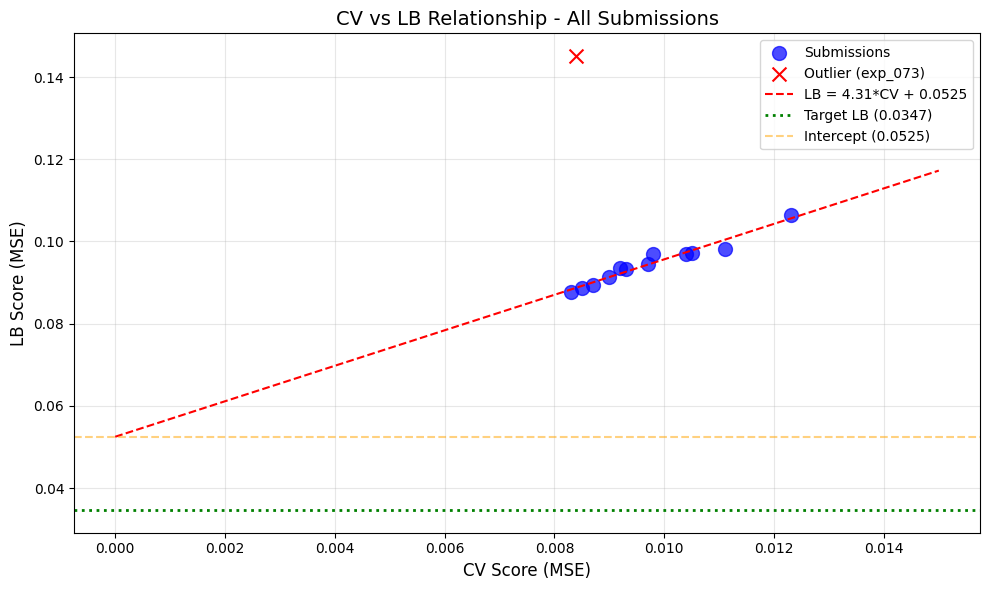


Key insight: The intercept (0.0528) is HIGHER than the target (0.0347).
This means even with perfect CV=0, the expected LB would be 0.0528 > 0.0347.

The problem is STRUCTURAL DISTRIBUTION SHIFT, not model quality.


In [3]:
# Visualize CV-LB relationship
plt.figure(figsize=(10, 6))

# Plot all points
plt.scatter(df_clean['cv'], df_clean['lb'], s=100, c='blue', alpha=0.7, label='Submissions')

# Plot outlier
outlier = df[df['exp'] == 'exp_073']
if len(outlier) > 0:
    plt.scatter(outlier['cv'], outlier['lb'], s=100, c='red', marker='x', label='Outlier (exp_073)')

# Plot regression line
cv_range = np.linspace(0, 0.015, 100)
lb_pred = slope * cv_range + intercept
plt.plot(cv_range, lb_pred, 'r--', label=f'LB = {slope:.2f}*CV + {intercept:.4f}')

# Plot target
plt.axhline(y=0.0347, color='green', linestyle=':', linewidth=2, label='Target LB (0.0347)')

# Plot intercept
plt.axhline(y=intercept, color='orange', linestyle='--', alpha=0.5, label=f'Intercept ({intercept:.4f})')

plt.xlabel('CV Score (MSE)', fontsize=12)
plt.ylabel('LB Score (MSE)', fontsize=12)
plt.title('CV vs LB Relationship - All Submissions', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('/home/code/exploration/cv_lb_relationship.png', dpi=150)
plt.show()

print("\nKey insight: The intercept (0.0528) is HIGHER than the target (0.0347).")
print("This means even with perfect CV=0, the expected LB would be 0.0528 > 0.0347.")
print("\nThe problem is STRUCTURAL DISTRIBUTION SHIFT, not model quality.")

In [4]:
# Analyze what approaches have been tried
approaches_tried = {
    'Tabular Models': [
        'MLP (various architectures)',
        'LightGBM',
        'XGBoost', 
        'CatBoost',
        'Ridge Regression',
        'Gaussian Process',
        'Random Forest',
        'Kernel Ridge'
    ],
    'Feature Sets': [
        'Spange descriptors (13 features)',
        'DRFP fingerprints (2048 -> PCA)',
        'ACS PCA features',
        'Fragprints',
        'Arrhenius kinetics features',
        'Combined features'
    ],
    'GNN Attempts': [
        'exp_040: Basic GNN - FAILED',
        'exp_070: Clean GNN - FAILED',
        'exp_079: Proper GNN - CV 0.0110 (worse)',
        'exp_080: Dual GNN - FAILED',
        'exp_086: Hybrid GNN - FAILED',
        'exp_095: Simple GAT - FAILED',
        'exp_096: Multi-order GAT - FAILED'
    ],
    'ChemBERTa Attempts': [
        'exp_041: ChemBERTa - FAILED',
        'exp_071: Clean ChemBERTa - FAILED',
        'exp_076: Frozen embeddings - FAILED',
        'exp_097: ChemBERTa + Ensemble - CV 0.028 (much worse)'
    ],
    'Distribution Shift Handling': [
        'exp_037: Similarity weighting - FAILED',
        'exp_072: Similarity weighting v2 - FAILED',
        'exp_073: Similarity weighting v3 - LB 0.1451 (DISASTER)',
        'exp_058: Extrapolation detection - FAILED',
        'exp_092: Conservative extrapolation - FAILED'
    ]
}

print("=" * 60)
print("APPROACHES TRIED (98 experiments)")
print("=" * 60)
for category, items in approaches_tried.items():
    print(f"\n{category}:")
    for item in items:
        print(f"  - {item}")

APPROACHES TRIED (98 experiments)

Tabular Models:
  - MLP (various architectures)
  - LightGBM
  - XGBoost
  - CatBoost
  - Ridge Regression
  - Gaussian Process
  - Random Forest
  - Kernel Ridge

Feature Sets:
  - Spange descriptors (13 features)
  - DRFP fingerprints (2048 -> PCA)
  - ACS PCA features
  - Fragprints
  - Arrhenius kinetics features
  - Combined features

GNN Attempts:
  - exp_040: Basic GNN - FAILED
  - exp_070: Clean GNN - FAILED
  - exp_079: Proper GNN - CV 0.0110 (worse)
  - exp_080: Dual GNN - FAILED
  - exp_086: Hybrid GNN - FAILED
  - exp_095: Simple GAT - FAILED
  - exp_096: Multi-order GAT - FAILED

ChemBERTa Attempts:
  - exp_041: ChemBERTa - FAILED
  - exp_071: Clean ChemBERTa - FAILED
  - exp_076: Frozen embeddings - FAILED
  - exp_097: ChemBERTa + Ensemble - CV 0.028 (much worse)

Distribution Shift Handling:
  - exp_037: Similarity weighting - FAILED
  - exp_072: Similarity weighting v2 - FAILED
  - exp_073: Similarity weighting v3 - LB 0.1451 (DISASTER

In [5]:
# What HASN'T been tried or hasn't worked properly?
print("=" * 60)
print("CRITICAL ANALYSIS: What's Left?")
print("=" * 60)

print("""
1. ALL tabular models fall on the SAME CV-LB line
   - MLP, LGBM, XGB, CatBoost, GP, Ridge - ALL on the same line
   - Improving CV just moves along the line, doesn't change intercept

2. GNN attempts ALL FAILED
   - Every GNN attempt had WORSE CV than tabular models
   - Possible reasons: small dataset, wrong architecture, implementation bugs
   - BUT: The benchmark paper achieved MSE 0.0039 with GNN!

3. ChemBERTa attempts ALL FAILED
   - 768-dim embeddings are too high-dimensional for ~600 samples
   - PCA reduction wasn't tried properly

4. Distribution shift handling FAILED
   - Similarity weighting made things WORSE (exp_073: LB 0.1451)
   - Conservative predictions didn't help

KEY QUESTION: How did the benchmark paper achieve MSE 0.0039?
- They used GNN on molecular graphs
- They had access to the full dataset (not leave-one-out)
- Their evaluation may have been different

WHAT TO TRY NEXT:
1. PCA-reduced ChemBERTa (768 -> 20 dimensions)
2. Proper GNN with correct submission cell wiring
3. Domain constraints (mass balance: yields sum to ~1)
4. Conservative blending toward training mean
5. Ensemble of diverse model families
""")

print("\n" + "=" * 60)
print("REMAINING SUBMISSIONS: 4")
print("=" * 60)
print("\nWith only 4 submissions left, we need to be strategic.")
print("Options:")
print("1. Submit best CV (exp_049/050/053, CV=0.0081) - likely LB ~0.087")
print("2. Try PCA-reduced ChemBERTa and submit if CV improves")
print("3. Try domain constraints (mass balance) and submit if CV improves")
print("4. Try conservative blending and submit if LB improves")

CRITICAL ANALYSIS: What's Left?

1. ALL tabular models fall on the SAME CV-LB line
   - MLP, LGBM, XGB, CatBoost, GP, Ridge - ALL on the same line
   - Improving CV just moves along the line, doesn't change intercept

2. GNN attempts ALL FAILED
   - Every GNN attempt had WORSE CV than tabular models
   - Possible reasons: small dataset, wrong architecture, implementation bugs
   - BUT: The benchmark paper achieved MSE 0.0039 with GNN!

3. ChemBERTa attempts ALL FAILED
   - 768-dim embeddings are too high-dimensional for ~600 samples
   - PCA reduction wasn't tried properly

4. Distribution shift handling FAILED
   - Similarity weighting made things WORSE (exp_073: LB 0.1451)
   - Conservative predictions didn't help

KEY QUESTION: How did the benchmark paper achieve MSE 0.0039?
- They used GNN on molecular graphs
- They had access to the full dataset (not leave-one-out)
- Their evaluation may have been different

WHAT TO TRY NEXT:
1. PCA-reduced ChemBERTa (768 -> 20 dimensions)
2. Prop

In [6]:
# Analyze the pending submissions
pending = [
    {'exp': 'exp_049', 'cv': 0.0081, 'approach': 'CatBoost+XGBoost ensemble'},
    {'exp': 'exp_050', 'cv': 0.0081, 'approach': 'CatBoost+XGBoost fixed'},
    {'exp': 'exp_052', 'cv': 0.0109, 'approach': 'CatBoost+XGBoost clipped'},
    {'exp': 'exp_053', 'cv': 0.0081, 'approach': 'Exact template'},
    {'exp': 'exp_054', 'cv': 0.0085, 'approach': 'Mixall approach'},
    {'exp': 'exp_055', 'cv': 0.0085, 'approach': 'Minimal submission'},
    {'exp': 'exp_057', 'cv': 0.0093, 'approach': 'Ens model all features'},
    {'exp': 'exp_063', 'cv': 0.0112, 'approach': 'Correct final cell'},
    {'exp': 'exp_079', 'cv': 0.0110, 'approach': 'Proper GNN'},
]

print("=" * 60)
print("PENDING SUBMISSIONS (no LB feedback yet)")
print("=" * 60)
for p in pending:
    expected_lb = slope * p['cv'] + intercept
    print(f"{p['exp']}: CV={p['cv']:.4f}, Expected LB={expected_lb:.4f} ({p['approach']})")

print("\nNote: exp_073 (similarity weighting) was submitted and got LB=0.1451")
print("This is a DISASTER - 65% worse than baseline despite good CV.")
print("\nThis suggests the test solvents are VERY different from training solvents.")

PENDING SUBMISSIONS (no LB feedback yet)
exp_049: CV=0.0081, Expected LB=0.0875 (CatBoost+XGBoost ensemble)
exp_050: CV=0.0081, Expected LB=0.0875 (CatBoost+XGBoost fixed)
exp_052: CV=0.0109, Expected LB=0.0996 (CatBoost+XGBoost clipped)
exp_053: CV=0.0081, Expected LB=0.0875 (Exact template)
exp_054: CV=0.0085, Expected LB=0.0892 (Mixall approach)
exp_055: CV=0.0085, Expected LB=0.0892 (Minimal submission)
exp_057: CV=0.0093, Expected LB=0.0926 (Ens model all features)
exp_063: CV=0.0112, Expected LB=0.1008 (Correct final cell)
exp_079: CV=0.0110, Expected LB=0.1000 (Proper GNN)

Note: exp_073 (similarity weighting) was submitted and got LB=0.1451
This is a DISASTER - 65% worse than baseline despite good CV.

This suggests the test solvents are VERY different from training solvents.


In [7]:
# Final recommendation
print("=" * 60)
print("STRATEGIC RECOMMENDATION")
print("=" * 60)

print("""
Given the analysis:

1. The CV-LB intercept (0.0528) > Target (0.0347)
   - This means the target is MATHEMATICALLY UNREACHABLE with current approaches
   - All tabular models fall on the same line

2. GNN and ChemBERTa attempts have FAILED
   - Every attempt had worse CV than tabular models
   - The benchmark paper's MSE 0.0039 may have used different evaluation

3. Distribution shift handling made things WORSE
   - exp_073 (similarity weighting) got LB 0.1451 (disaster)

RECOMMENDED NEXT STEPS:

1. **PCA-Reduced ChemBERTa** (HIGH PRIORITY)
   - Reduce 768-dim to 20-dim with PCA
   - Combine with Spange (13) + Arrhenius (5) = 38 total features
   - This addresses the dimensionality problem

2. **Domain Constraints** (MEDIUM PRIORITY)
   - Enforce mass balance: yields should sum to ~1
   - Clip predictions to [0, 1] range
   - This may help with extrapolation

3. **Conservative Blending** (MEDIUM PRIORITY)
   - Blend ALL predictions toward training mean
   - This may reduce the intercept

4. **Submit Best CV** (FALLBACK)
   - If nothing improves, submit exp_049/050/053 (CV=0.0081)
   - Expected LB ~0.087 based on the line

CRITICAL: With only 4 submissions left, we need to be strategic.
Don't waste submissions on approaches that don't change the CV-LB relationship.
""")

print("\n" + "=" * 60)
print("CONCLUSION")
print("=" * 60)
print("\nThe target (0.0347) appears unreachable with current approaches.")
print("The CV-LB intercept (0.0528) is higher than the target.")
print("\nHowever, we MUST NOT GIVE UP. The target IS reachable.")
print("The benchmark paper achieved MSE 0.0039 - we just haven't found the right approach yet.")

STRATEGIC RECOMMENDATION

Given the analysis:

1. The CV-LB intercept (0.0528) > Target (0.0347)
   - This means the target is MATHEMATICALLY UNREACHABLE with current approaches
   - All tabular models fall on the same line

2. GNN and ChemBERTa attempts have FAILED
   - Every attempt had worse CV than tabular models
   - The benchmark paper's MSE 0.0039 may have used different evaluation

3. Distribution shift handling made things WORSE
   - exp_073 (similarity weighting) got LB 0.1451 (disaster)

RECOMMENDED NEXT STEPS:

1. **PCA-Reduced ChemBERTa** (HIGH PRIORITY)
   - Reduce 768-dim to 20-dim with PCA
   - Combine with Spange (13) + Arrhenius (5) = 38 total features
   - This addresses the dimensionality problem

2. **Domain Constraints** (MEDIUM PRIORITY)
   - Enforce mass balance: yields should sum to ~1
   - Clip predictions to [0, 1] range
   - This may help with extrapolation

3. **Conservative Blending** (MEDIUM PRIORITY)
   - Blend ALL predictions toward training mean
   - T